# Self Case Study-2_Severstal: Steel Defect Detection - Can you detect and classify defects in steel?

## Section-III

## 5. Final Model Pipeline

In [43]:
#importing usefull library
import pandas as pd
import numpy as np
import os
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import pandas_profiling as pp
from tqdm import tqdm
import sys
from PIL import Image, ImageDraw
from PIL import ImagePath
import urllib
import tensorflow as tf
# import matplotlib.pyplot as plt
from sklearn import preprocessing
from numpy import save ,load
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout, Input, MaxPool2D , Flatten
import pickle
import random
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.metrics import iou_score
from tensorflow.keras import callbacks
import imgaug.augmenters as iaa

In [35]:
os.chdir('C:/Users/Vikrant Mohite/Desktop/Applied AI/Case Study-2')
os.getcwd()

'C:\\Users\\Vikrant Mohite\\Desktop\\Applied AI\\Case Study-2'

In [181]:
train_images_path = "C:/Users/Vikrant Mohite/Desktop/Applied AI/Case Study-2/train_images"
train_csv_path = "train.csv"
RGB_image_arr_pkl_path = "C:/Users/Vikrant Mohite/Desktop/Applied AI/Case Study-2/RGB_image_arr.pkl"
masks_path = "C:/Users/Vikrant Mohite/Desktop/Applied AI/Case Study-2/output1"
mask_5d_path = "C:/Users/Vikrant Mohite/Desktop/Applied AI/Case Study-2/mask_5d"
best_model_path = "C:/Users/Vikrant Mohite/Desktop/Applied AI/Case Study-2/best_model_unet.h5"

In [168]:
def Preprocess_data(train_images_path, train_csv_path):
    
    # Reading csv file, generating dataframe
    pd.options.display.max_columns=50
    train_df = pd.read_csv(train_csv_path)
    train_images = os.listdir(train_images_path)
    train_images_df = pd.DataFrame(train_images,columns =['ImageId'])
    train_images_df.head()
    train_df_mearged = pd.merge(train_df,train_images_df,how = 'outer',on = ['ImageId','ImageId'])
    train_df_mearged['ClassId'].fillna(value=0,inplace=True)
    
    # Generating dataframe of paths of the defective images of given dataset
    list1 = []
    list2 = []
    for path, dirc, files in os.walk(train_images_path):
        for name in files:
            list1.append(name)
    for index, row in tqdm(train_df.iterrows()):
        if row.ImageId in list1 and row.ClassId !=0: 
            list2.append(train_images_path + '/' + row.ImageId)            
    df1 = pd.DataFrame((list2), columns = ["image_path"])
    pd.set_option('display.max_colwidth', None)
    
    # Generating numpy array of shape of the given images from the EncodedPixels given in 'train' csv file
    train_numpy_masks = []
    for index, row in tqdm(train_df_mearged.iterrows()):
        img = np.zeros(1600*256, dtype=np.uint8)    
        if row.ClassId !=0:
            p = row.EncodedPixels.split()
            starts, lengths = [np.asarray(x, dtype=int) for x in (p[0::2], p[1::2])]
            starts -= 1
            ends = starts + lengths
            for lo, hi in zip(starts, ends):
                img[lo:hi] = row.ClassId 
            img = img.reshape(1600,256).T
            train_numpy_masks.append(img)    
    
    # The below code adds the color map into numpy array generated above
    if (os.path.exists(RGB_image_arr_pkl_path) == False):
        RGB_image_list = []
        for img in tqdm(train_numpy_masks):
            RGB_image = []
            for i in img :
                lst1 = []
                for j in i :
                    lst1.append(classes_tocolour.get(j))  
                RGB_image.append(lst1)
            c = np.array(RGB_image)
            RGB_image_list.append(c)
        
        RGB_image_arr = np.array(RGB_image_list, dtype=np.int8)
        
        with open('RGB_image_arr.pkl', 'wb') as f:
            pickle.dump(RGB_image_arr, f)
    
    # Generating ans saving mask images for given images of dataset
    if(os.path.exists(masks_path) == False):
        os.makedirs (masks_path)
        p = masks_path
        file = open("RGB_image_arr.pkl",'rb')
        RGB_image_arr = pickle.load(file)
        file.close()
        for k, (i, j) in tqdm(enumerate(zip(RGB_image_arr, train_df['ImageId'].values))):
            mask_img = Image.fromarray(i.astype(np.uint8))
            mask_name = j.split('.')[0] + '_' + str(k) + '_mask.png'
            mask_path = os.path.join(p, '/', mask_name)
            mask_img.save(mask_path)
    
    # saving paths of masks 
    train_masks = os.listdir(masks_path)
    df1['mask_path'] = train_masks
    df1['mask_path'] = "C:/Users/Vikrant Mohite/Desktop/Applied AI/Case Study-2/output1/" + df1['mask_path']
    
    df1['image_path'] = sorted(df1['image_path'])
    df1['mask_path'] = sorted(df1['mask_path'])
    
    
    # generating 5 dimensional numpy array from masks
    if(os.path.exists(mask_5d_path) == False):
        os.makedirs (mask_5d_path)
        q = mask_5d_path
        colourmap = [[0, 0, 0], [255, 105, 180], [ 180,255,105],[ 105, 180,255], [255, 255,105]]

        for k, (mask, j) in tqdm(enumerate(zip(RGB_image_arr, train_df['ImageId'].values))):
            output_mask = []
            for i , color in enumerate(colourmap):
                cmap = np.all(np.equal(mask , color ), axis = -1)
                cmap.astype(int)
                output_mask.append(cmap)
            output_mask = np.stack(output_mask , axis = -1)
            output_mask = output_mask.astype(np.uint8)

            mask_name1 = j.split('.')[0] + '_' + str(k) + '.npy'
            mask_path1 = os.path.join(q, mask_name1)
            save(mask_path1, output_mask)
    
    # saving paths of 5d numpy array     
    train_masks_5d = os.listdir(mask_5d_path)
    df1['mask_path_5d'] = train_masks_5d
    df1['mask_path_5d'] = "C:/Users/Vikrant Mohite/Desktop/Applied AI/Case Study-2/mask_5d/" + df1['mask_path_5d']
    df1['image_path'] = sorted(df1['image_path'])
    df1['mask_path'] = sorted(df1['mask_path'])
    df1['mask_path_5d'] = sorted(df1['mask_path_5d']) 

    from sklearn.model_selection import train_test_split
    train, validation = train_test_split(df1, test_size=0.3, random_state=42)
    validation, test = train_test_split(validation, test_size=0.3, random_state=42)
    
    print('df1_shape:', df1.shape)
    print('train_shape:', train.shape)
    print('validation_shape:', validation.shape)
    print('test_shape:', test.shape)
    
    
    return df1, train, validation, test

In [170]:
df1, train, validation, test = Preprocess_data(train_images_path, train_csv_path)

In [33]:
def Visualizing_data(df):

    images_ = df['image_path'].values
    masks_ = df["mask_path"].values
    lst1 = np.arange(len(images_))
    
    ids = np.random.choice(lst1, size = 20, replace = False)
    
    for i in ids:
      image = cv2.imread(images_[i], cv2.IMREAD_UNCHANGED)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = np.expand_dims(image, axis=0)

      mask  = cv2.imread(masks_[i], cv2.IMREAD_UNCHANGED)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

#       pred = model.predict(image,verbose=1)
#       pred = tf.argmax(pred, axis=-1)

      fig = plt.figure(figsize=(20,14))

      ax1 = fig.add_subplot(1, 3, 1)
      ax1.imshow(image[0,:,:])
      ax2=fig.add_subplot(1, 3, 2)
      ax2.imshow(mask)
#       ax3=fig.add_subplot(1, 3, 3)
#       ax3.imshow(pred[0,:,:])
      ax1.title.set_text('Image')
      ax2.title.set_text('Original Mask')
#       ax3.title.set_text('Predicted Mask')
      plt.show()
    

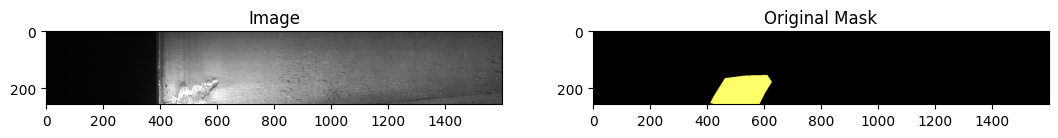

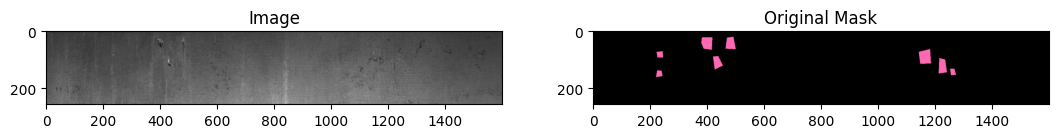

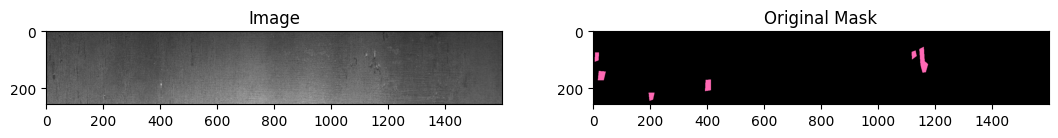

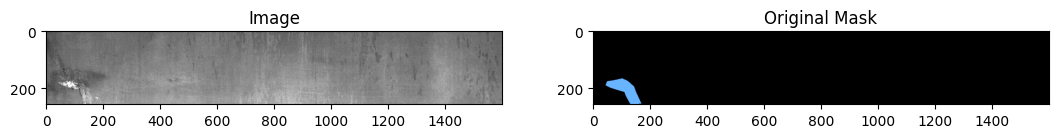

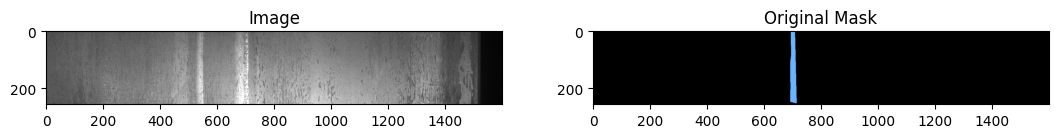

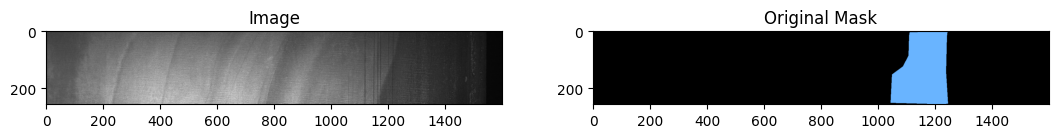

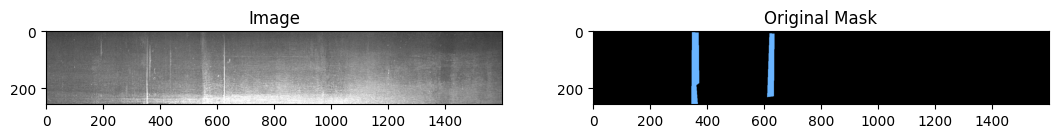

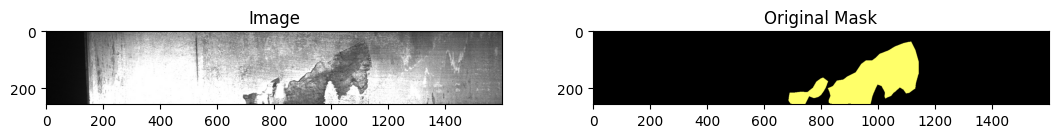

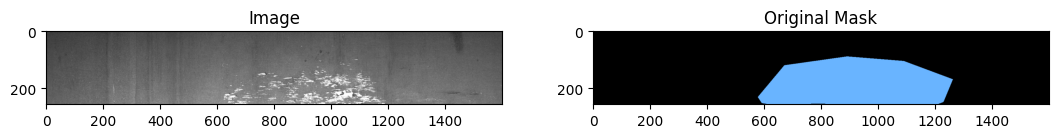

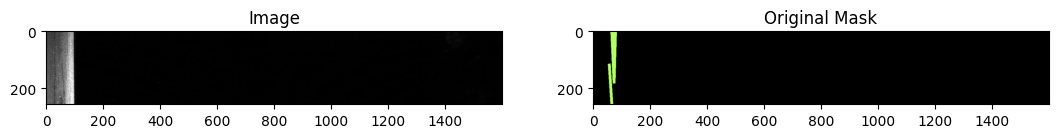

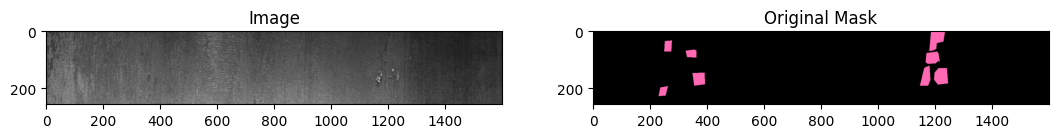

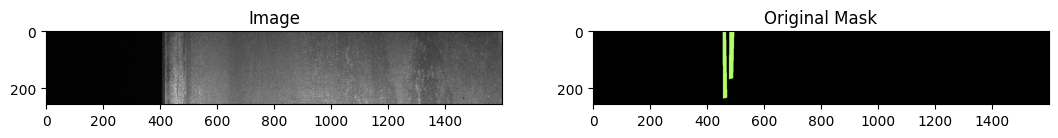

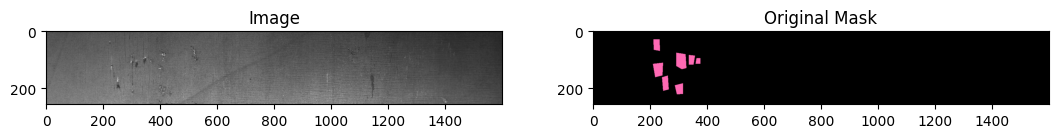

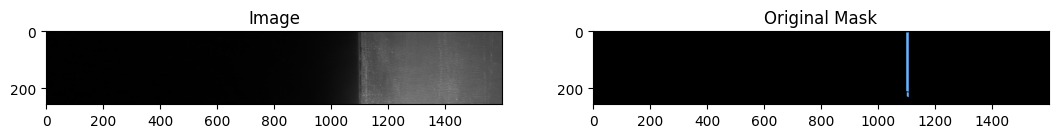

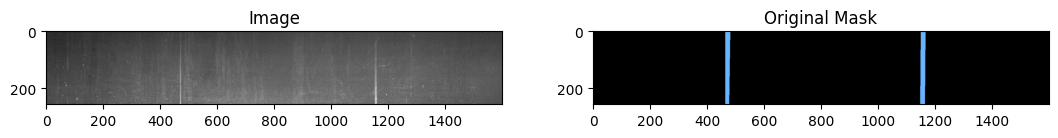

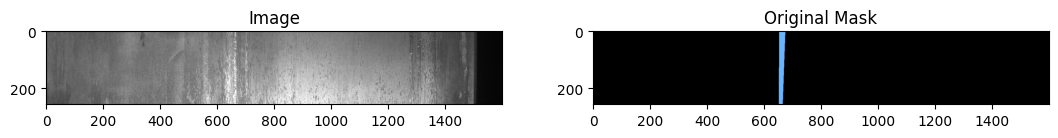

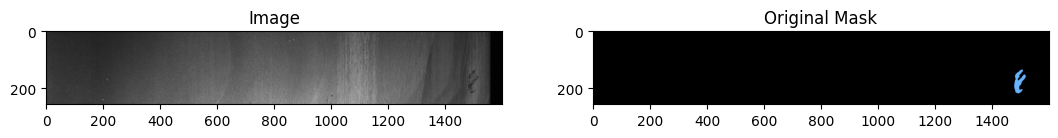

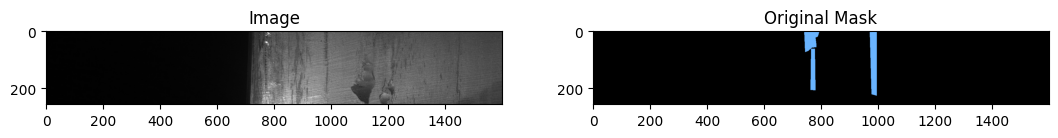

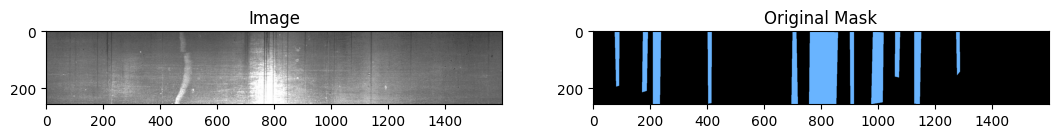

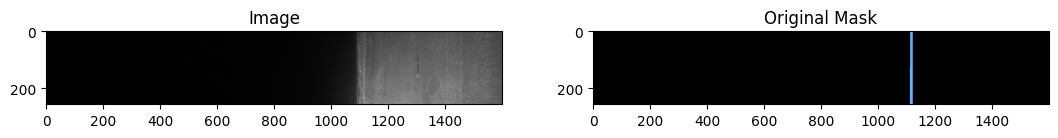

In [34]:
Visualizing_data(train)

In [ ]:
# !pip install segmentation_models

In [135]:
class Dataset:
    
    def __init__(self, data_df):   
        self.images_fps   = data_df['image_path'].values
        self.masks_fps  = data_df['mask_path_5d'].values

    def __getitem__(self, i): #https://omkarpathak.in/2018/04/11/python-getitem-and-setitem/
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('float')

        
        image_mask = load(self.masks_fps[i])
        image_mask = image_mask.astype('float')
        
        aug1 = iaa.Fliplr(1)
        aug2 = iaa.Flipud(1)
        aug3 = iaa.Emboss(alpha=(1), strength=1)
        aug4 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
        aug5 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))
        
        a = np.random.uniform()
        if a<0.2:
            image = aug1.augment_image(image)
            image_mask = aug1.augment_image(image_mask)
        elif a<0.4:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.6:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.8:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        else:
            image = aug5.augment_image(image)
            image_mask = aug5.augment_image(image_mask)
   
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)

In [136]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [137]:
def data_generator(train, validation):
    train_dataset1 = Dataset(train)
    validation_dataset1  = Dataset(validation)
    
    BATCH_SIZE=10
    
    train_dataloader = Dataloder(train_dataset1, batch_size=BATCH_SIZE, shuffle=True)
    validation_dataloader = Dataloder(validation_dataset1, batch_size=BATCH_SIZE, shuffle=True)

    assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 1600, 3)
    assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 1600, 5)

    print(train_dataloader[0][0].shape)
    print(train_dataloader[0][1].shape)
    print(len(train_dataloader))
    print(len(validation_dataloader))
    type(train_dataset[0])
    
    return train_dataset1, validation_dataset1, train_dataloader, validation_dataloader

In [138]:
train_dataset1, validation_dataset1, train_dataloader, validation_dataloader = data_generator(train, validation)

(10, 256, 1600, 3)
(10, 256, 1600, 5)
496
149


In [182]:
def training_model(train_images_path, train_csv_path):
    df1, train, validation, test = Preprocess_data(train_images_path, train_csv_path)
    train_dataset1, validation_dataset1, train_dataloader, validation_dataloader = data_generator(train, validation)
    
    if(os.path.exists(best_model_path) == False):
        tf.keras.backend.clear_session()
        sm.set_framework('tf.keras')
        tf.keras.backend.set_image_data_format('channels_last')
        # loading the unet model and using the resnet 50 and initialized weights with Imagenet weights.
        backbone = 'resnet50'
        IMAGE_SHAPE = (256, 1600, 3)
        
        model = Unet(backbone_name = backbone, input_shape = IMAGE_SHAPE, classes = 5, activation = 'softmax', \
                     encoder_freeze = True, encoder_weights = 'imagenet', decoder_block_type = 'upsampling')
        
        optim = tf.keras.optimizers.Adam(learning_rate= 0.001)
        focal_loss = sm.losses.cce_dice_loss
        model.compile(optim, focal_loss, metrics=[iou_score])
        
        callbacks = [callbacks.ModelCheckpoint('./best_model.h5', save_weights_only = True, save_best_only = True, \
                    mode = 'max', monitor = 'val_iou_score', verbose = 1), callbacks.ReduceLROnPlateau(\
                    monitor = 'val_iou_score', patience = 3, mode = 'max', verbose = 1,min_lr=0.0001,factor=0.2)]


        history = model.fit(train_dataloader, steps_per_epoch=(len(train_dataloader))//BATCH_SIZE, epochs=8,\
                        validation_data=test_dataloader, callbacks=callbacks)
        
    else:
        tf.keras.backend.clear_session()
        sm.set_framework('tf.keras')
        tf.keras.backend.set_image_data_format('channels_last')
        # loading the unet model and using the resnet 50 and initialized weights with Imagenet weights.
        backbone = 'resnet50'
        IMAGE_SHAPE = (256, 1600, 3)
        model = Unet(backbone_name = backbone, input_shape = IMAGE_SHAPE, classes = 5, activation = 'softmax', \
                     encoder_freeze = True, encoder_weights = 'imagenet', decoder_block_type = 'upsampling')
        
        optim = tf.keras.optimizers.Adam(learning_rate= 0.001)
        focal_loss = sm.losses.cce_dice_loss
        model.compile(optim, focal_loss, metrics=[iou_score])

        model.load_weights(best_model_path)
        
    return model

In [183]:
model = training_model(train_images_path, train_csv_path)

7095it [00:00, 9353.13it/s] 
12997it [00:09, 1355.32it/s] 


df1_shape: (7095, 3)
train_shape: (4966, 3)
validation_shape: (1490, 3)
test_shape: (639, 3)
(10, 256, 1600, 3)
(10, 256, 1600, 5)
496
149


In [191]:
def Visualizing_result(df, model):

    images_ = df['image_path'].values
    masks_ = df["mask_path"].values
    lst1 = np.arange(len(images_))
    
    ids = np.random.choice(lst1, size = 20, replace = False)
    
    for i in ids:
      image = cv2.imread(images_[i], cv2.IMREAD_UNCHANGED)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = np.expand_dims(image, axis=0)

      mask  = cv2.imread(masks_[i], cv2.IMREAD_UNCHANGED)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

      pred = model.predict(image,verbose=1)
      pred = tf.argmax(pred, axis=-1)

      fig = plt.figure(figsize=(20,14))

      ax1 = fig.add_subplot(1, 3, 1)
      ax1.imshow(image[0,:,:])
      ax2=fig.add_subplot(1, 3, 2)
      ax2.imshow(mask)
      ax3=fig.add_subplot(1, 3, 3)
      ax3.imshow(pred[0,:,:])
      ax1.title.set_text('Image')
      ax2.title.set_text('Original Mask')
      ax3.title.set_text('Predicted Mask')
      plt.show()
    

1/1 [==============================] - 0s 92ms/step


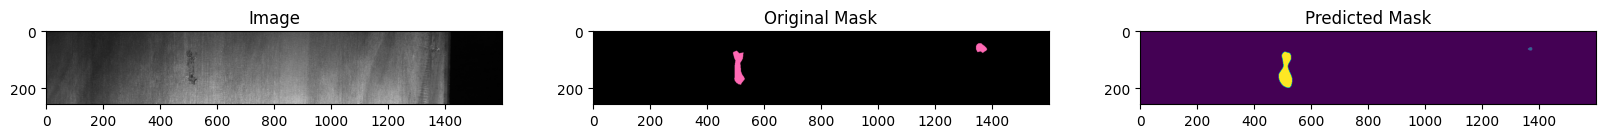

1/1 [==============================] - 0s 86ms/step


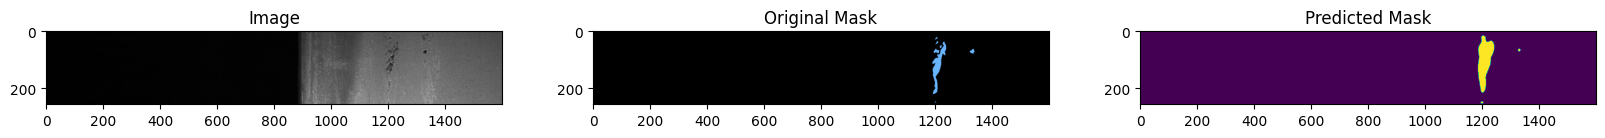

1/1 [==============================] - 0s 76ms/step


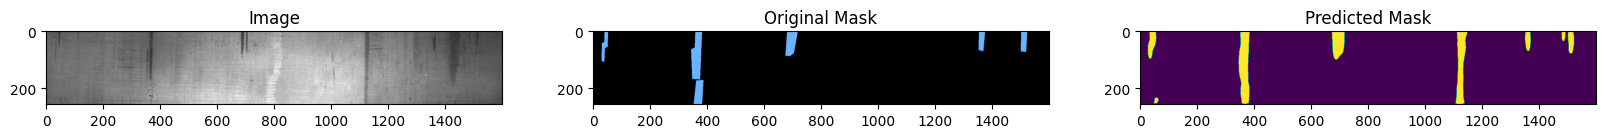

1/1 [==============================] - 0s 84ms/step


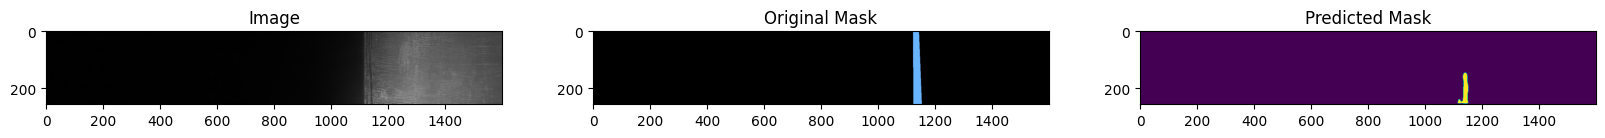

1/1 [==============================] - 0s 79ms/step


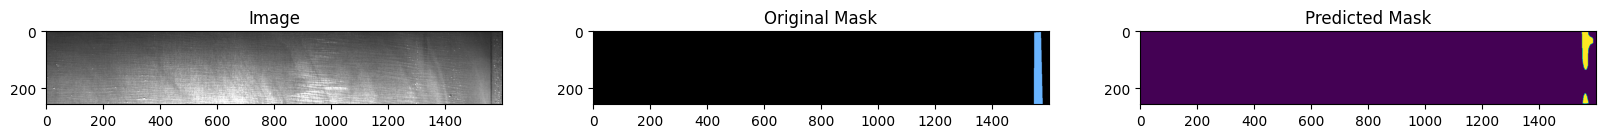

1/1 [==============================] - 0s 79ms/step


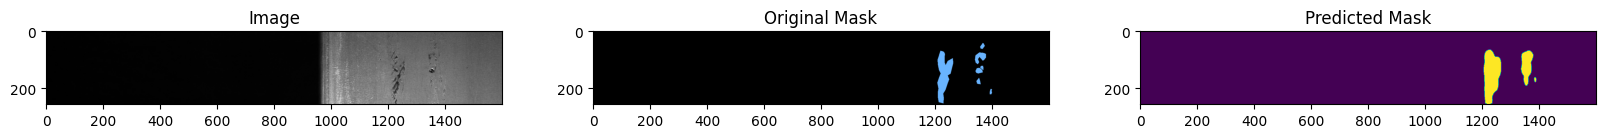

1/1 [==============================] - 0s 80ms/step


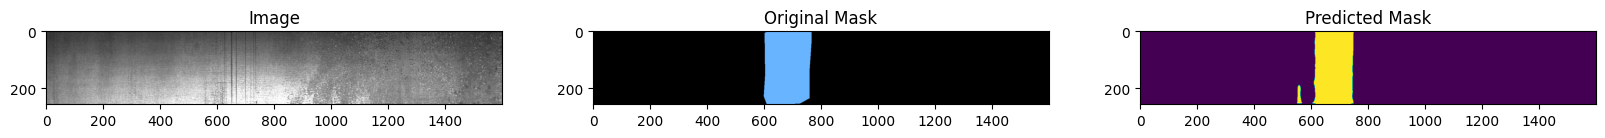

1/1 [==============================] - 0s 82ms/step


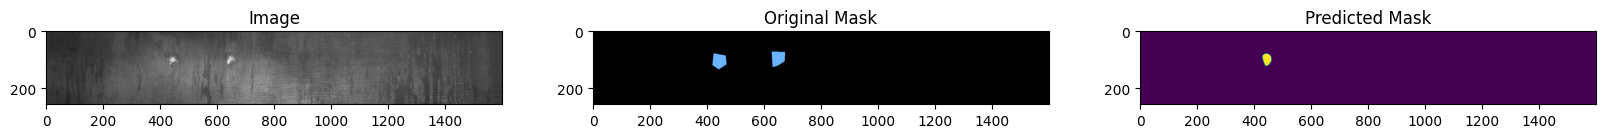

1/1 [==============================] - 0s 86ms/step


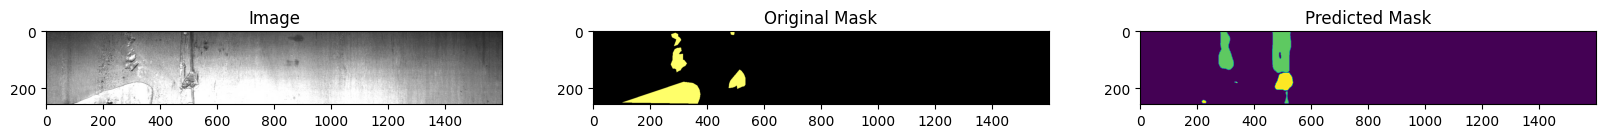

1/1 [==============================] - 0s 86ms/step


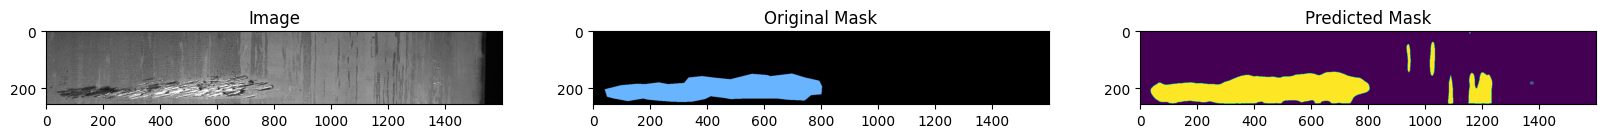

1/1 [==============================] - 0s 79ms/step


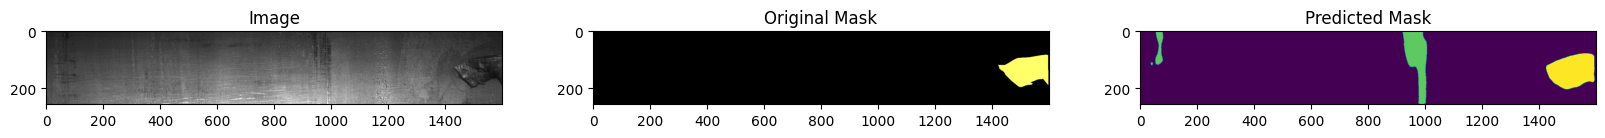

1/1 [==============================] - 0s 84ms/step


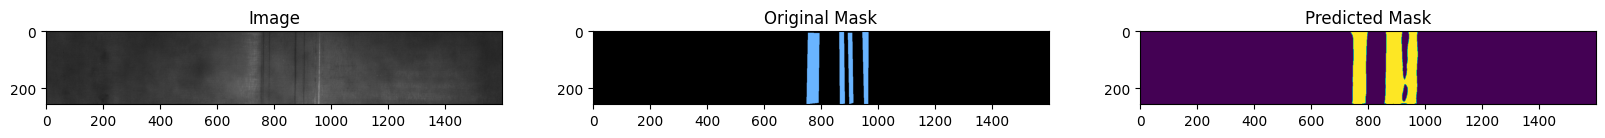

1/1 [==============================] - 0s 64ms/step


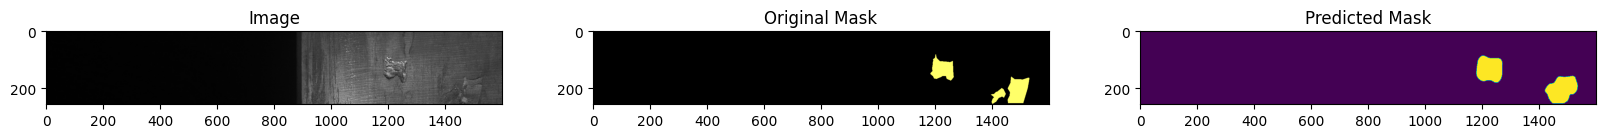

1/1 [==============================] - 0s 63ms/step


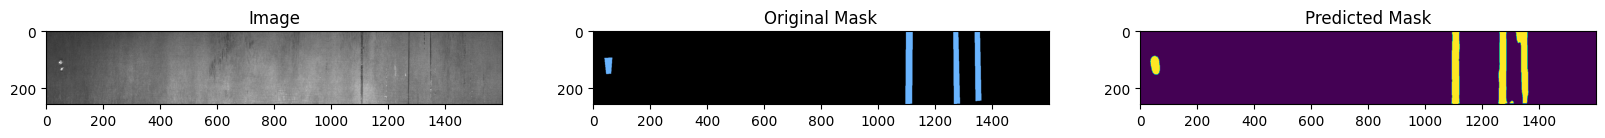

1/1 [==============================] - 0s 78ms/step


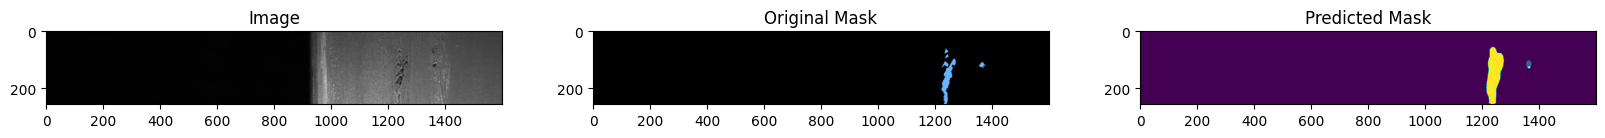

1/1 [==============================] - 0s 78ms/step


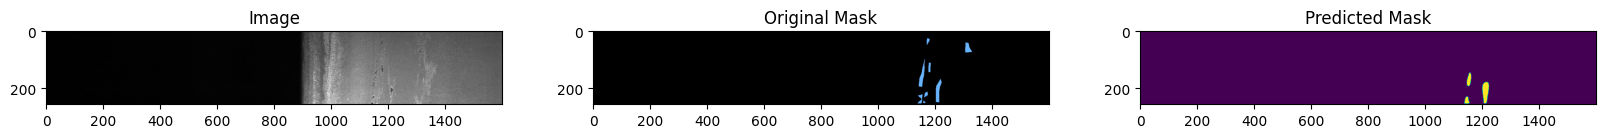

1/1 [==============================] - 0s 76ms/step


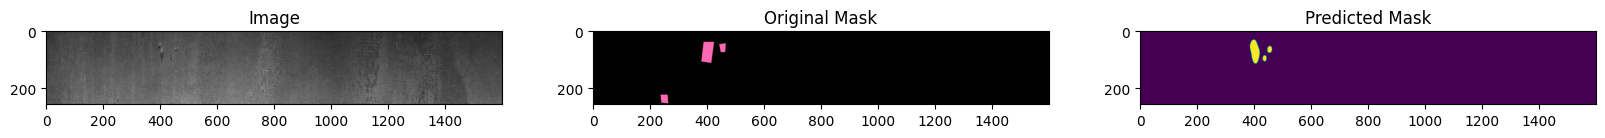

1/1 [==============================] - 0s 79ms/step


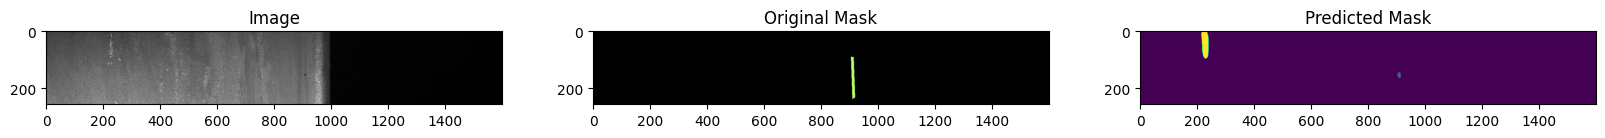

1/1 [==============================] - 0s 71ms/step


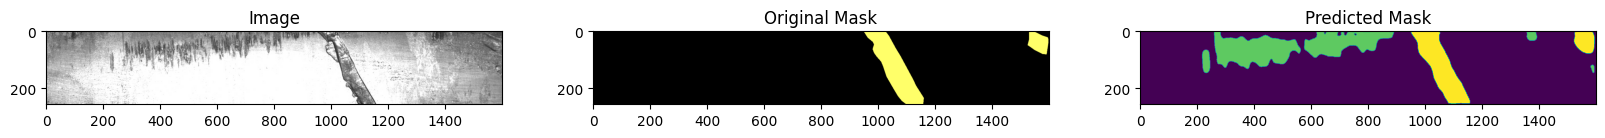

1/1 [==============================] - 0s 71ms/step


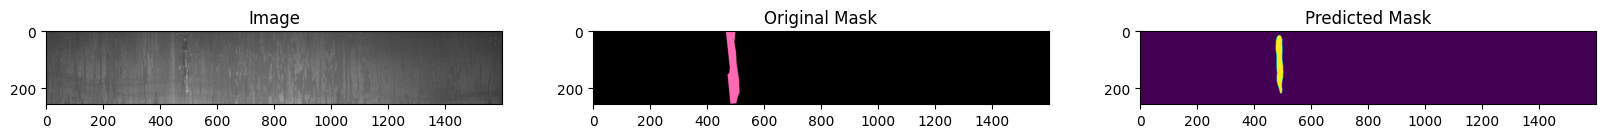

In [192]:
Visualizing_result(test, model)